### Tasks
1. Determine the performance of storing vehicle roster as a pandas dataframe. 
2. Compare the departure time profile with smoothing to the one without


Change log

v1: 2018-12-07

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
import os
from time import time
import gc

In [3]:
DYNUS_T_DATA_DIR = 'C:\Projects\Repo\Work\SWIFT\data\Dynus_T'
vehicle_roster_file_deliv = 'vehicles_deliv_17.csv'
vehicle_roster_file_deliv = os.path.join(DYNUS_T_DATA_DIR, vehicle_roster_file_deliv)
vehicle_roster_file_deliv

'C:\\Projects\\Repo\\Work\\SWIFT\\data\\Dynus_T\\vehicles_deliv_17.csv'

In [4]:
# The file has two header rows. The second row has the column defs. 


# 55669           1    # of vehicles in the file, Max # of STOPs
#  #   usec   dsec   stime vehcls vehtype ioc #ONode #IntDe info ribf    comp   izone Evac InitPos    VoT  tFlag pArrTime TP IniGas
#  1 115449 278035    12.7     3     6     1     1     1     0  0.0000  0.0000     5     0  0.92110000    0.00    0    0.0    5  0.0
#    61   0.00

dtypes = {
    '#':np.int32,
    'usec': np.int32,   
    'dsec': np.int32,   
    'stime': np.float32, 
    'vehcls': np.uint8, 
    'vehtype': np.uint8, 
    'ioc': np.uint8, 
    '#ONode': np.uint32, 
    '#IntDe': np.uint16, 
    'info': np.uint8,
    'ribf': np.float16,    
    'comp': np.float16,   
    'izone': np.uint16, 
    'Evac': np.uint8, 
    'InitPos': np.float32,    
    'VoT': np.float32,  
    'tFlag': np.uint8, 
    'pArrTime': np.float16, 
    'TP': np.uint8, 
    'IniGas': np.float16,
    'DZone': np.uint16,
    'waitTime': np.float
}


In [5]:
start_time = time()
df_vehicles_deliv = pd.read_csv(vehicle_roster_file_deliv, skiprows=0, header=0,
                                sep=',', 
                                dtype=dtypes,  
                               )
end_time = time()
print("{0:d} trips read in {1:.0f} seconds".format(df_vehicles_deliv.shape[0], (end_time-start_time)))

19301935 trips read in 73 seconds


In [6]:
df_vehicles_deliv.head()

,vid,usec,dsec,stime,vehcls,vehtype,ioc,#ONode,#IntDe,info,...,Izone,Evac,InitPos,VoT,tFlag,pArrTime,TP,IniGas,DZone,waitTime
0,1,252555,14547,0.0,3,1,0,8,1,0,...,2774,0,0.7882,23.65,0,0.0,2,0.0,2782,0.0
1,2,322244,313074,0.0,3,1,0,12,1,0,...,2816,0,0.6758,23.65,0,0.0,2,0.0,2729,0.0
2,3,271541,82019,0.0,3,6,1,123,1,0,...,961,0,0.2846,64.00,0,0.0,5,0.0,5248,0.0
3,4,306502,302598,0.0,3,5,1,28,1,0,...,5077,0,0.6623,40.00,0,0.0,5,0.0,430,0.0
4,5,24808,294441,0.0,3,1,0,2,1,0,...,328,0,0.6336,20.48,0,0.0,1,0.0,328,0.0


In [7]:
df_vehicles_deliv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19301935 entries, 0 to 19301934
Data columns (total 22 columns):
vid         int64
usec        int32
dsec        int32
stime       float32
vehcls      uint8
vehtype     uint8
ioc         uint8
#ONode      uint32
#IntDe      uint16
info        uint8
ribf        float16
comp        float16
Izone       int64
Evac        uint8
InitPos     float32
VoT         float32
tFlag       uint8
pArrTime    float16
TP          uint8
IniGas      float16
DZone       uint16
waitTime    float64
dtypes: float16(4), float32(3), float64(1), int32(2), int64(2), uint16(2), uint32(1), uint8(7)
memory usage: 1.2 GB


In [8]:
# stime mean/std probably overflowed.
min_stime, max_stime = df_vehicles_deliv.stime.values.min(), df_vehicles_deliv.stime.values.max()
min_vot, max_vot = df_vehicles_deliv.VoT.values.min(), df_vehicles_deliv.VoT.values.max()
min_zone, max_zone = 1, 5262
min_tp, max_tp = df_vehicles_deliv.TP.values.min(), df_vehicles_deliv.TP.values.max()
min_ioc, max_ioc = df_vehicles_deliv.ioc.values.min(), df_vehicles_deliv.ioc.values.max()
min_vehtype, max_vehtype = df_vehicles_deliv.vehtype.values.min(), df_vehicles_deliv.vehtype.values.max()

In [9]:
index_columns = ['Izone', 'DZone', 'TP', 'ioc', 'vehtype']
vehicle_counts = df_vehicles_deliv.groupby(by=index_columns)['vid'].count()

(array([6.401635e+06, 1.520800e+04, 3.832000e+03, 1.552000e+03,
        6.980000e+02, 3.660000e+02, 2.450000e+02, 1.400000e+02,
        1.050000e+02, 7.300000e+01, 4.700000e+01, 3.300000e+01,
        3.000000e+01, 1.300000e+01, 2.500000e+01, 7.000000e+00,
        7.000000e+00, 8.000000e+00, 8.000000e+00, 4.000000e+00,
        1.000000e+00, 0.000000e+00, 5.000000e+00, 1.000000e+00,
        4.000000e+00, 3.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.000000e+00, 0.000000e+00, 3.000000e+00,
        0.000000e+00, 0.000000e+00, 2.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 2.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.000000e+00]),
 array([1.0000e+00, 6.2100e+01, 1.2320e+02, 1.8430e+02, 2.4540e+02,
        3.0650e+02, 3.6760e+02, 4.2870e+02, 4.8980e+02, 5.5090e+02,
        6.1200e+02, 6.7310e+02, 7.3420e+02, 7.9530e+02, 8.

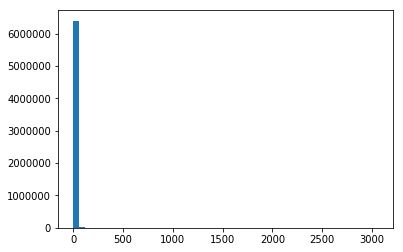

In [12]:
plt.hist(, bins=50)

Most OD pairs only have only a few trips. 

#### Generate random instructions

In [150]:
df_vehicles_deliv.reset_index(inplace=True)

In [151]:
NUMBER_OF_INSTRUCTIONS = 100

In [177]:
def generate_instructions(n, df_vehicles, index_col=['Izone', 'DZone', 'TP', 'ioc', 'vehtype']):
    """
    n: number of instructions to generate
    """
    
    global min_stime, max_stime, min_vot, max_vot, min_zone, max_zone, min_tp, max_tp, min_ioc, max_ioc
    global min_vehtype, max_veh_type
    
    stime_lb = np.random.uniform(low=min_stime, high=max_stime, size=n)
    stime_buffer = np.random.randint(low=1, high=4, size=n)
    stime_hb = np.clip(stime_lb + stime_buffer, a_min=0, a_max=max_stime)
    
    vot_lb = np.random.uniform(low=min_vot, high=max_vot, size=n)
    vot_buffer = np.random.randint(15, size=n)
    vot_hb = np.clip(vot_lb + vot_buffer, a_min=min_vot, a_max=max_stime)
    
    select_index = df_vehicles_deliv.loc[:,index_col].values[np.random.randint(df_vehicles_deliv.shape[0],size=n)]
    
#     origins = np.random.choice(np.arange(1,max_zone+1), replace=True, size=n)
#     destinations = np.random.choice(np.arange(1,max_zone+1), replace=True, size=n)
    
#     purposes = np.random.choice(np.arange(1,max_tp+1), replace=True, size=n)
#     occs = np.random.choice(np.arange(1,max_ioc+1), replace=True, size=n)
#     vehtypes = np.random.choice(np.arange(1,max_vehtype+1), replace=True, size=n)
    
    changes = np.random.choice(np.arange(-10,10), replace=True, size=n)
    
    return np.column_stack((select_index, stime_lb, stime_hb, vot_lb, vot_hb))
    

In [178]:
instructions = generate_instructions(5, df_vehicles_deliv)
instructions.shape

KeyError: "None of [['Izone', 'DZone', 'TP', 'ioc', 'vehtype']] are in the [columns]"

In [156]:
instructions

array([[1.86100000e+03, 9.22000000e+02, 5.00000000e+00, 0.00000000e+00,
        4.00000000e+00, 4.91067415e+02, 4.91067415e+02, 3.52688743e+01,
        3.82688743e+01],
       [2.14800000e+03, 2.15100000e+03, 3.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 1.32560663e+03, 1.32560663e+03, 8.00006848e+01,
        8.50006848e+01],
       [1.02000000e+03, 1.99000000e+03, 2.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 1.15546470e+03, 1.15646470e+03, 7.76582831e+01,
        8.56582831e+01],
       [5.13000000e+02, 1.24200000e+03, 4.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 2.11379807e+02, 2.13379807e+02, 6.29048065e+01,
        6.29048065e+01],
       [3.39100000e+03, 1.47300000e+03, 4.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 6.24282569e+02, 6.24282569e+02, 4.09324973e+01,
        4.49324973e+01]])

In [154]:
def timeit(func):
    def f(*args, **kwargs):
        args = list(args)
        start_time = time()
        rv = func(*args, **kwargs)
        end_time = time()
        print("Execution time = {0:.0f} sec".format(end_time-start_time))
        return rv
    return f

In [155]:
@timeit
def find_vehicles(df_vehicles, instructions):
    vehicle_count = 0
    vehicles_invalid = []
    for instruction in instructions:
        anchor = tuple(instruction[:5])
        if df_vehicles.index.contains(anchor):
            chosen = df_vehicles.loc[anchor]
            stime_lb, stime_hb, vot_lb, vot_hb = tuple(instruction[5:])
            selection_time = (df_vehicles.stime >= stime_lb) & (df_vehicles.stime <= stime_hb)
            selection_vot = (df_vehicles.VoT >= vot_lb) & (df_vehicles.VoT <= vot_hb)
            chosen = df_vehicles.loc[selection_time & selection_vot]
            if chosen.shape[0] > 0:
                vehicle_count += chosen.shape[0]
        else:
            vehicles_invalid.append(anchor)
    return vehicle_count, vehicles_invalid

In [161]:
df_vehicles_deliv.set_index(index_columns, inplace=True)

In [111]:
df_vehicles_deliv_subset = df_vehicles_deliv.head()

In [162]:
vehicle_count, vehicles_invalid = find_vehicles(df_vehicles_deliv, instructions)

KeyError: 'the label [1861.0] is not in the [index]'

In [159]:
print(vehicle_count)

0


In [163]:
df_vehicles_deliv.index.contains((1861.0, 922.0, 5.0, 0.0, 4.0))

True

In [164]:
df_vehicles_deliv.loc[(1861.0, 922.0, 5.0, 0.0, 4.0)]

vid    usec   dsec       stime  vehcls  \
Izone DZone TP ioc vehtype                                               
1861  922   5  0   4        6852616  282965  39460  709.900024       3   
                   4        7184080  282965  79489  726.900024       3   

                            #ONode  #IntDe  info      ribf  comp  Evac  \
Izone DZone TP ioc vehtype                                               
1861  922   5  0   4            24       1     0  0.199951   0.0     0   
                   4            15       1     0  0.199951   0.0     0   

                            InitPos        VoT  tFlag  pArrTime  IniGas  \
Izone DZone TP ioc vehtype                                                
1861  922   5  0   4         0.1381  18.940001      0       0.0     0.0   
                   4         0.7025  18.940001      0       0.0     0.0   

                            waitTime  
Izone DZone TP ioc vehtype            
1861  922   5  0   4             0.0  
                   4             0.0

In [173]:
stime_lb = np.random.uniform(low=min_stime, high=max_stime, size=5)
stime_buffer = np.random.randint(low=1, high=3, size=5)
stime_hb = np.clip(stime_lb + stime_buffer, a_min=0, a_max=max_stime)

In [174]:
stime_lb, stime_buffer, stime_hb

(array([ 884.16911472, 1260.11489003,   62.51035024, 1111.04520824,
         616.14279798]),
 array([2, 1, 1, 1, 1]),
 array([ 886.16911472, 1261.11489003,   63.51035024, 1112.04520824,
         617.14279798]))

In [176]:
np.clip(stime_lb + stime_buffer, a_min=0, a_max=max_stime)

array([ 886.16911472, 1261.11489003,   63.51035024, 1112.04520824,
        617.14279798])

In [145]:
a = np.arange(6)
a.resize((3,2))
b = np.arange(9)
b.resize(3,3)
np.column_stack((a,b))

array([[0, 1, 0, 1, 2],
       [2, 3, 3, 4, 5],
       [4, 5, 6, 7, 8]])

In [146]:
a, b

(array([[0, 1],
        [2, 3],
        [4, 5]]), array([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]))

False

In [121]:
df_vehicles_deliv.tail()

vid  usec    dsec       stime  vehcls  \
Izone DZone TP ioc vehtype                                               
5262  5106  5  0   1         7110806  6210  449173  723.099976       3   
      5110  5  0   1         5190815  6210  449173  619.099976       3   
      5127  5  0   1          787126  6210  449173  369.000000       3   
      5165  5  0   1         1527686  6210  449173  422.000000       3   
      5188  5  0   1        11087053  6210  449173  914.900024       3   

                            #ONode  #IntDe  info      ribf  comp  Evac  \
Izone DZone TP ioc vehtype                                               
5262  5106  5  0   1           114       1     0  0.199951   0.0     0   
      5110  5  0   1           110       1     0  0.199951   0.0     0   
      5127  5  0   1            91       1     0  0.199951   0.0     0   
      5165  5  0   1           120       1     0  0.199951   0.0     0   
      5188  5  0   1           136       1     0  0.199951   0.0     0   

                            InitPos        VoT  tFlag  pArrTime  IniGas  \
Izone DZone TP ioc vehtype                                                
5262  5106  5  0   1         0.5196  18.940001      0       0.0     0.0   
      5110  5  0   1         0.5298  18.940001      0       0.0     0.0   
      5127  5  0   1         0.1345  18.940001      0       0.0     0.0   
      5165  5  0   1         0.8096  18.940001      0       0.0     0.0   
      5188  5  0   1         0.8081  18.940001      0       0.0     0.0   

                            waitTime  
Izone DZone TP ioc vehtype            
5262  5106  5  0   1             0.0  
      5110  5  0   1             0.0  
      5127  5  0   1             0.0  
      5165  5  0   1             0.0  
      5188  5  0   1             0.0

In [126]:
np.random.randint(10,size=3)

array([9, 4, 0])

In [29]:
instructions

array([[3.65600000e+03, 6.31000000e+02, 3.00000000e+00, 2.00000000e+00,
        4.00000000e+00, 8.50234510e+02, 8.51234510e+02, 1.81683354e+01,
        3.01683354e+01],
       [4.15600000e+03, 9.74000000e+02, 4.00000000e+00, 1.00000000e+00,
        5.00000000e+00, 2.30026686e+02, 2.32026686e+02, 7.58008792e+01,
        8.18008792e+01],
       [6.02000000e+02, 3.64000000e+03, 3.00000000e+00, 1.00000000e+00,
        2.00000000e+00, 6.20933658e+02, 6.21933658e+02, 2.46636549e+01,
        3.06636549e+01],
       [4.20100000e+03, 6.75000000e+02, 3.00000000e+00, 1.00000000e+00,
        2.00000000e+00, 1.10438983e+03, 1.10438983e+03, 3.64461683e+01,
        3.64461683e+01],
       [2.07500000e+03, 1.51800000e+03, 3.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 8.54478299e+02, 8.55478299e+02, 7.13732313e+00,
        2.11373231e+01]])

In [82]:
arrays = [np.arange(8), np.array([1,2,1,2,1,2,1,2])]
arrays

[array([0, 1, 2, 3, 4, 5, 6, 7]), array([1, 2, 1, 2, 1, 2, 1, 2])]

In [83]:
s = pd.Series(np.random.randn(8), index=arrays)
s

0  1    0.165646
1  2   -0.170022
2  1   -0.776249
3  2    1.709138
4  1    0.036056
5  2   -0.569341
6  1   -0.674400
7  2    1.323972
dtype: float64

In [89]:
s.index

MultiIndex(levels=[[0, 1, 2, 3, 4, 5, 6, 7], [1, 2]],
           labels=[[0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 0, 1, 0, 1, 0, 1]])

In [102]:
s.index.contains((1,3))

False

In [98]:
idx = pd.IndexSlice
s.loc[idx[1], idx[3]]

IndexingError: Too many indexers